In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
import MySQLdb as mdb
# from definitions import DATABASE_CONFIG_DIR, INCOME_STATEMENT_DIR

## load stock info

In [14]:
with open('../../database/database_config/database.ymal') as f:
    db_config = yaml.load(f, Loader=yaml.FullLoader)
db = mdb.connect(host=db_config['db_host'], user=db_config['db_user'], passwd=db_config['db_pass'],
                 db=db_config['db_name'], use_unicode=True, charset="utf8")
# select stockId and ticker from table stock_info
table_name = 'stock_info'
column_list = ['stockId', 'ticker', 'IndustryGroup']
columns = ','.join(column_list)
req = """SELECT %s FROM %s WHERE sp500=TRUE """ % (columns, table_name)
get_stock_info_cursor = db.cursor()
get_stock_info_cursor.execute(req)
stock_info = get_stock_info_cursor.fetchall()
get_stock_info_cursor.close()

#create dataframe
df_stock_info = pd.DataFrame(stock_info, columns=column_list)

In [15]:
df_stock_info.head(5)

,stockId,ticker,IndustryGroup
0,11,PNR,Machinery
1,37,ALLE,Building Materials
2,45,ITW,Machinery
3,48,AMAT,Semiconductor Equip
4,52,NWL,Household Products


## load the file

In [16]:
file = '../20210608_valuation_result_sp500.csv'
df_valuation = pd.read_csv(file)

In [17]:
df_valuation.head(5)

,ticker,current_price,estimated_value,price_to_value
0,PNR,69.52,32.952902,2.109678
1,ALLE,138.83,81.129186,1.711221
2,ITW,235.81,83.538171,2.822781
3,AMAT,139.85,91.670900,1.525566
4,NWL,28.27,10.113064,2.795394


In [18]:
df_valuation.describe()

,current_price,estimated_value,price_to_value
count,491.000000,489.000000,489.000000
mean,184.043422,119.416888,1.034074
std,314.954288,400.783557,21.415746
min,13.800000,-270.467724,-327.698154
25%,63.045000,18.439807,0.784199
50%,116.920000,60.336509,1.578206
75%,210.290000,117.459128,2.579432
max,4810.000000,5965.583610,148.255271


## merge two dataframes

In [19]:
df = pd.merge(df_valuation, df_stock_info, left_on='ticker', right_on='ticker', how='left')

In [20]:
## filter out finanace sector 
df = df.loc[(df['IndustryGroup']!='Financial Svcs. (Non-bank & Insurance)')
                 & (df['IndustryGroup']!='Banks (Regional)') 
                 & (df['IndustryGroup']!='Bank (Money Center)') 
                 & (df['IndustryGroup']!='Brokerage & Investment Banking') 
                 & (df['IndustryGroup']!='Investments & Asset Management') 
                 & (df['IndustryGroup']!='Insurance (Life)')
                 & (df['IndustryGroup']!='Insurance (Prop/Cas.)')
                 & (df['IndustryGroup']!='Insurance (General)')]

## EDA

array([[<AxesSubplot:title={'center':'price_to_value'}>]], dtype=object)

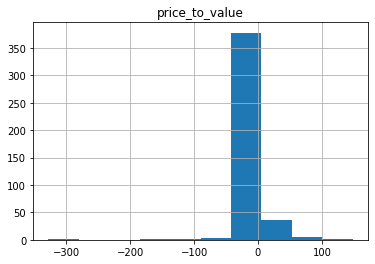

In [21]:
df.hist(column="price_to_value")

### calculate the range

In [22]:
def cut_to(x):
    if x<0:
        return 'less than 0'
    elif x<1:
        return '0-1'
    else:
        return 'larger than 1'

df['valuation_range'] = df['price_to_value'].map(cut_to)

In [23]:
df

,ticker,current_price,estimated_value,price_to_value,stockId,IndustryGroup,valuation_range
0,PNR,69.52,32.952902,2.109678,11,Machinery,larger than 1
1,ALLE,138.83,81.129186,1.711221,37,Building Materials,larger than 1
2,ITW,235.81,83.538171,2.822781,45,Machinery,larger than 1
3,AMAT,139.85,91.670900,1.525566,48,Semiconductor Equip,larger than 1
4,NWL,28.27,10.113064,2.795394,52,Household Products,larger than 1
...,...,...,...,...,...,...,...
500,UAL,56.93,-62.801429,-0.906508,9772,Air Transport,less than 0
501,CDW,167.49,109.982646,1.522877,9829,Computer Services,larger than 1
502,MU,83.76,98.714240,0.848510,9839,Semiconductor,0-1
503,DLTR,101.80,121.141442,0.840340,9850,Retail (General),0-1


In [24]:
df['valuation_range'].value_counts()

larger than 1    318
less than 0       64
0-1               61
Name: valuation_range, dtype: int64

## sort

In [25]:
df.sort_values(by=['price_to_value'])

,ticker,current_price,estimated_value,price_to_value,stockId,IndustryGroup,valuation_range
15,LUV,58.55,-0.178671,-327.698154,185,Air Transport,less than 0
412,IQV,233.84,-1.655495,-141.250830,7842,Heathcare Information and Technology,less than 0
487,WMB,27.95,-0.231647,-120.657525,9505,Oil/Gas Distribution,less than 0
414,FRT,117.63,-1.111499,-105.830036,7926,R.E.I.T.,less than 0
406,WYNN,128.16,-2.038560,-62.867897,7638,Hotel/Gaming,less than 0
...,...,...,...,...,...,...,...
361,FLIR,NaN,NaN,NaN,6671,Electronics (General),larger than 1
370,AMCR,NaN,NaN,NaN,6912,empty,larger than 1
401,GOOGL,NaN,NaN,NaN,7514,empty,larger than 1
456,CBOE,NaN,NaN,NaN,8855,empty,larger than 1


### select the valuation between 0-1

In [26]:
df = df.loc[df['valuation_range'] == '0-1']
df = df.sort_values(by=['price_to_value'])

array([[<AxesSubplot:title={'center':'price_to_value'}>]], dtype=object)

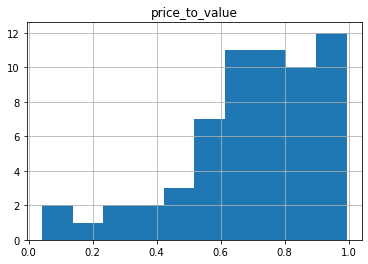

In [27]:
df.hist(column="price_to_value")

In [28]:
df.head(10)

,ticker,current_price,estimated_value,price_to_value,stockId,IndustryGroup,valuation_range
23,CI,252.94,5965.583610,0.042400,344,Healthcare Support Services,0-1
479,DXC,39.89,532.978086,0.074844,9425,Computer Services,0-1
489,VIAC,41.70,198.405607,0.210176,9557,Broadcasting,0-1
275,FOXA,37.19,119.335585,0.311642,5061,Broadcasting,0-1
492,LHX,222.75,694.057794,0.320939,9622,Aerospace/Defense,0-1
377,ABBV,112.36,291.108121,0.385973,7038,Drugs (Biotechnology),0-1
26,CNC,71.44,175.779179,0.406419,375,Healthcare Support Services,0-1
405,FB,330.35,651.625789,0.506963,7538,Software (Entertainment),0-1
382,CPB,49.68,97.574921,0.509147,7066,Food Processing,0-1
425,VRTX,209.93,405.799581,0.517324,8155,Drugs (Biotechnology),0-1


In [29]:
df.loc[(df['price_to_value']>0.1) & (df['price_to_value']<0.8)]

,ticker,current_price,estimated_value,price_to_value,stockId,IndustryGroup,valuation_range
489,VIAC,41.70,198.405607,0.210176,9557,Broadcasting,0-1
275,FOXA,37.19,119.335585,0.311642,5061,Broadcasting,0-1
492,LHX,222.75,694.057794,0.320939,9622,Aerospace/Defense,0-1
377,ABBV,112.36,291.108121,0.385973,7038,Drugs (Biotechnology),0-1
26,CNC,71.44,175.779179,0.406419,375,Healthcare Support Services,0-1
405,FB,330.35,651.625789,0.506963,7538,Software (Entertainment),0-1
382,CPB,49.68,97.574921,0.509147,7066,Food Processing,0-1
425,VRTX,209.93,405.799581,0.517324,8155,Drugs (Biotechnology),0-1
194,LEN,96.60,181.948076,0.530921,3614,Homebuilding,0-1
132,CAH,56.56,102.922154,0.549542,2448,Healthcare Support Services,0-1
